In [1]:
from rl4greencrab.envs.simple_env import SimpleEnv
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import pandas as pd
import numpy as np
from rl4greencrab import plot_agent
import ray
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective

INFO: Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO: Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO: NumExpr defaulting to 16 threads.
/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [2]:
from rl4greencrab import greenCrabMonthEnvSimple, greenCrabMonthEnvSimpleNormalized, greenCrabMonthEnvSize, greenCrabMonthEnvSizeNormalized

In [3]:
from rl4greencrab import greenCrabMonthEnvTwoAct, greenCrabMonthEnvTwoActNormalized, greenCrabMonthEnvTwoActSize, greenCrabMonthEnvTwoActSizeNormalized

In [4]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}

In [5]:
env = greenCrabMonthEnvTwoActNormalized(config)
vec_env = make_vec_env(greenCrabMonthEnvTwoActNormalized, n_envs=12)

In [8]:
model = PPO("MultiInputPolicy", vec_env, verbose=0)
model.learn(
	total_timesteps=1_000, 
	progress_bar=True,
)

Output()

In [5]:
def evaluateConstAct(x):
    config = {
        "w_mort_scale" : 600,
        "growth_k": 0.70,
        'random_start':True,
        'var_penalty_const': 0
        # "curriculum": True
    }
    env = greenCrabMonthEnvTwoAct(config=config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    return - m_reward

In [6]:
ray.init()

2025-09-29 17:26:17,439	INFO worker.py:1951 -- Started a local Ray instance.


Python version:,3.12.11
Ray version:,2.49.2


(simulator pid=949) /opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
(simulator pid=949)   gym.logger.warn(


In [7]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 2*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.7100
Function value obtained: 10.4364
Current minimum: 10.4364
Iteration No: 2 started. Evaluating function at random point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3764
Function value obtained: 7.5438
Current minimum: 7.5438
Iteration No: 3 started. Evaluating function at random point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3610
Function value obtained: 10.6243
Current minimum: 7.5438
Iteration No: 4 started. Evaluating function at random point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}
I

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.5372
Function value obtained: 20.7720
Current minimum: 7.4997
Iteration No: 12 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.5295
Function value obtained: 7.3580
Current minimum: 7.3580
Iteration No: 13 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5632
Function value obtained: 7.1874
Current minimum: 7.1874
Iteration No: 14 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5332
Function value obtained: 7.0367
Current minimum: 7.0367
Iteration No: 15 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4917
Function value obtained: 6.7969
Current minimum: 6.7969
Iteration No: 16 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.4841
Function value obtained: 7.1621
Current minimum: 6.7969
Iteration No: 17 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.5355
Function value obtained: 9.6036
Current minimum: 6.7969
Iteration No: 18 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5083
Function value obtained: 7.1243
Current minimum: 6.7969
Iteration No: 19 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5667
Function value obtained: 8.8978
Current minimum: 6.7969
Iteration No: 20 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5688
Function value obtained: 6.8563
Current minimum: 6.7969
Iteration No: 21 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.5696
Function value obtained: 6.6115
Current minimum: 6.6115
Iteration No: 22 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5480
Function value obtained: 9.9313
Current minimum: 6.6115
Iteration No: 23 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.5737
Function value obtained: 7.1728
Current minimum: 6.6115
Iteration No: 24 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5533
Function value obtained: 6.9415
Current minimum: 6.6115
Iteration No: 25 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5587
Function value obtained: 6.8623
Current minimum: 6.6115
Iteration No: 26 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5792
Function value obtained: 7.1454
Current minimum: 6.6115
Iteration No: 27 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5856
Function value obtained: 6.9384
Current minimum: 6.6115
Iteration No: 28 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.7498
Function value obtained: 6.7886
Current minimum: 6.6115
Iteration No: 29 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.5851
Function value obtained: 7.0333
Current minimum: 6.6115
Iteration No: 30 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5561
Function value obtained: 6.5885
Current minimum: 6.5885
Iteration No: 31 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.5823
Function value obtained: 6.6743
Current minimum: 6.5885
Iteration No: 32 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.5719
Function value obtained: 6.6431
Current minimum: 6.5885
Iteration No: 33 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.6109
Function value obtained: 6.7831
Current minimum: 6.5885
Iteration No: 34 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.5758
Function value obtained: 6.6766
Current minimum: 6.5885
Iteration No: 35 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.6325
Function value obtained: 6.4976
Current minimum: 6.4976
Iteration No: 36 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.5791
Function value obtained: 6.5954
Current minimum: 6.4976
Iteration No: 37 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.6100
Function value obtained: 6.3323
Current minimum: 6.3323
Iteration No: 38 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.6111
Function value obtained: 6.5103
Current minimum: 6.3323
Iteration No: 39 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.5994
Function value obtained: 6.6315
Current minimum: 6.3323
Iteration No: 40 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.6688
Function value obtained: 6.2719
Current minimum: 6.2719
Iteration No: 41 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.6327
Function value obtained: 6.5622
Current minimum: 6.2719
Iteration No: 42 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.6443
Function value obtained: 6.4645
Current minimum: 6.2719
Iteration No: 43 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.6424
Function value obtained: 8.1818
Current minimum: 6.2719
Iteration No: 44 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.6852
Function value obtained: 6.3991
Current minimum: 6.2719
Iteration No: 45 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.6993
Function value obtained: 6.5823
Current minimum: 6.2719
Iteration No: 46 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.6758
Function value obtained: 6.4625
Current minimum: 6.2719
Iteration No: 47 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.7369
Function value obtained: 6.4326
Current minimum: 6.2719
Iteration No: 48 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.7864
Function value obtained: 6.3584
Current minimum: 6.2719
Iteration No: 49 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.8435
Function value obtained: 6.2980
Current minimum: 6.2719
Iteration No: 50 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.8501
Function value obtained: 6.4354
Current minimum: 6.2719
Iteration No: 51 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.7850
Function value obtained: 6.4889
Current minimum: 6.2719
Iteration No: 52 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 0.8249
Function value obtained: 6.4323
Current minimum: 6.2719
Iteration No: 53 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 0.9621
Function value obtained: 6.3855
Current minimum: 6.2719
Iteration No: 54 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.7747
Function value obtained: 6.4213
Current minimum: 6.2719
Iteration No: 55 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.8023
Function value obtained: 7.4502
Current minimum: 6.2719
Iteration No: 56 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.8428
Function value obtained: 6.2354
Current minimum: 6.2354
Iteration No: 57 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 0.8106
Function value obtained: 6.4786
Current minimum: 6.2354
Iteration No: 58 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.8078
Function value obtained: 12.0850
Current minimum: 6.2354
Iteration No: 59 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 0.8654
Function value obtained: 6.7491
Current minimum: 6.2354
Iteration No: 60 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 0.8272
Function value obtained: 6.2029
Current minimum: 6.2029
Iteration No: 61 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 0.8621
Function value obtained: 6.4461
Current minimum: 6.2029
Iteration No: 62 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 0.8928
Function value obtained: 6.2412
Current minimum: 6.2029
Iteration No: 63 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 0.8805
Function value obtained: 6.4565
Current minimum: 6.2029
Iteration No: 64 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 0.9260
Function value obtained: 6.3311
Current minimum: 6.2029
Iteration No: 65 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 0.9334
Function value obtained: 9.8525
Current minimum: 6.2029
Iteration No: 66 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 0.9053
Function value obtained: 6.1634
Current minimum: 6.1634
Iteration No: 67 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 0.9325
Function value obtained: 7.7786
Current minimum: 6.1634
Iteration No: 68 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 0.9251
Function value obtained: 6.1803
Current minimum: 6.1634
Iteration No: 69 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 0.9449
Function value obtained: 6.4723
Current minimum: 6.1634
Iteration No: 70 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 0.9301
Function value obtained: 6.4582
Current minimum: 6.1634
Iteration No: 71 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 0.9490
Function value obtained: 6.2734
Current minimum: 6.1634
Iteration No: 72 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 0.9443
Function value obtained: 9.0062
Current minimum: 6.1634
Iteration No: 73 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 0.9771
Function value obtained: 6.6650
Current minimum: 6.1634
Iteration No: 74 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 0.9554
Function value obtained: 13.3887
Current minimum: 6.1634
Iteration No: 75 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 0.9254
Function value obtained: 6.2643
Current minimum: 6.1634
Iteration No: 76 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 0.9411
Function value obtained: 6.3206
Current minimum: 6.1634
Iteration No: 77 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.1193
Function value obtained: 6.4576
Current minimum: 6.1634
Iteration No: 78 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.0118
Function value obtained: 6.4287
Current minimum: 6.1634
Iteration No: 79 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 1.0132
Function value obtained: 6.5078
Current minimum: 6.1634
Iteration No: 80 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.0198
Function value obtained: 8.2003
Current minimum: 6.1634
Iteration No: 81 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 0.9593
Function value obtained: 7.7853
Current minimum: 6.1634
Iteration No: 82 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.0307
Function value obtained: 8.1178
Current minimum: 6.1634
Iteration No: 83 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.0331
Function value obtained: 6.3879
Current minimum: 6.1634
Iteration No: 84 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.0516
Function value obtained: 6.2720
Current minimum: 6.1634
Iteration No: 85 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.0166
Function value obtained: 6.4055
Current minimum: 6.1634
Iteration No: 86 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.0975
Function value obtained: 11.4858
Current minimum: 6.1634
Iteration No: 87 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 1.0781
Function value obtained: 6.5197
Current minimum: 6.1634
Iteration No: 88 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 1.0180
Function value obtained: 6.2982
Current minimum: 6.1634
Iteration No: 89 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 1.0249
Function value obtained: 6.2111
Current minimum: 6.1634
Iteration No: 90 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.0374
Function value obtained: 6.3728
Current minimum: 6.1634
Iteration No: 91 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.1547
Function value obtained: 6.4294
Current minimum: 6.1634
Iteration No: 92 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.1389
Function value obtained: 6.3004
Current minimum: 6.1634
Iteration No: 93 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.1497
Function value obtained: 6.3175
Current minimum: 6.1634
Iteration No: 94 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.1650
Function value obtained: 6.5392
Current minimum: 6.1634
Iteration No: 95 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 1.1961
Function value obtained: 6.3331
Current minimum: 6.1634
Iteration No: 96 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1.1877
Function value obtained: 6.5140
Current minimum: 6.1634
Iteration No: 97 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.2286
Function value obtained: 6.2146
Current minimum: 6.1634
Iteration No: 98 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.2192
Function value obtained: 6.2269
Current minimum: 6.1634
Iteration No: 99 started. Searching for the next optimal point.
False
{'node:10.42.0.12': 1.0, 'object_store_memory': 20054184345.0, 'node:__internal_head__': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 1.2254
Function value obtained: 6.6097
Current minimum: 6.1634
Iteration No: 100 started. Searching for the next optimal point.
False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'CPU': 128.0, 'memory': 46793096807.0}


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 1.2067
Function value obtained: 6.3581
Current minimum: 6.1634
CPU times: user 49min 9s, sys: 9.46 s, total: 49min 19s
Wall time: 1min 27s


[911.9806873317767, 541.2329811836053]

In [8]:
evaluateConstAct(np.array([911.9806873317767, 541.2329811836053]))

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


False
{'node:__internal_head__': 1.0, 'object_store_memory': 20054184345.0, 'node:10.42.0.12': 1.0, 'memory': 46793096807.0, 'CPU': 128.0}


6.264502880390601

In [9]:
ray.shutdown()

In [5]:
agent_dir = '../saved_agents/twoActEnv'
td3Agent = TD3.load(f"{agent_dir}/TD3-twoactmonthnorm-1", device="cpu")
ppoAgent = PPO.load(f"{agent_dir}/PPO-twoactmonthnorm-net", device="cpu")
tqcAgent = TQC.load(f"{agent_dir}/TQC-twoactmonthnorm-1", device="cpu")
recurrentPPOAgent = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-twoactmonthnorm-net", device="cpu")

In [7]:
td3Agent_var = TD3.load(f"{agent_dir}/TD3-twoactmonthnorm-2", device="cpu")
ppoAgent_var = PPO.load(f"{agent_dir}/PPO-twoactmonthnorm-2", device="cpu")
tqcAgent_var = TQC.load(f"{agent_dir}/TQC-twoactmonthnorm-2", device="cpu")
recurrentPPOAgent_var = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-twoactmonthnorm-2", device="cpu")

In [11]:
agent_dir = '../saved_agents/twoActEnv'
td3Agent = TD3.load(f"{agent_dir}/TD3-twoactmonthsizenorm-1", device="cpu")
ppoAgent = PPO.load(f"{agent_dir}/PPO-twoactmonthsizenorm-1", device="cpu")
tqcAgent = TQC.load(f"{agent_dir}/TQC-twoactmonthsizenorm-1", device="cpu")
recurrentPPOAgent_net = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-twoactmonthsizenorm-1", device="cpu")

In [10]:
evalEnv = greenCrabMonthEnvTwoActSizeNormalized(config)

In [ ]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)

In [12]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [15]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -5.647436046773448
PPO mean rew = -4.9227849399788175
TQC mean rew = -5.5542557144808375
TD3 mean rew = -9.517992154888828
RecurrentPPO mean rew = -21.418132147772933
RecurrentPPO mean rew = -20.774922666985766



In [11]:
ppo_rew = evaluate_agent(agent=ppoAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [15]:
ray.shutdown()

In [12]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -4.941728964112845
TQC mean rew = -3.8339277102703635
TD3 mean rew = -4.0519980256366335
RecurrentPPO mean rew = -7.371229518656801



In [34]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0,
    'control_randomness': True
    # "curriculum": True
}

In [32]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


,t,obs0,obs1,act0,act1,rew,rep
0,0,-1.0,-1.0,-1.000000,-1.000000,0.000000,0
1,1,-1.0,-1.0,-1.000000,-0.652212,-0.000061,0
2,2,-1.0,-1.0,-1.000000,-0.806397,-0.014034,0
3,3,-1.0,-1.0,-1.000000,-0.328863,-0.021839,0
4,4,-1.0,-1.0,-0.715252,-0.549271,-0.048746,0


<Axes: xlabel='t'>

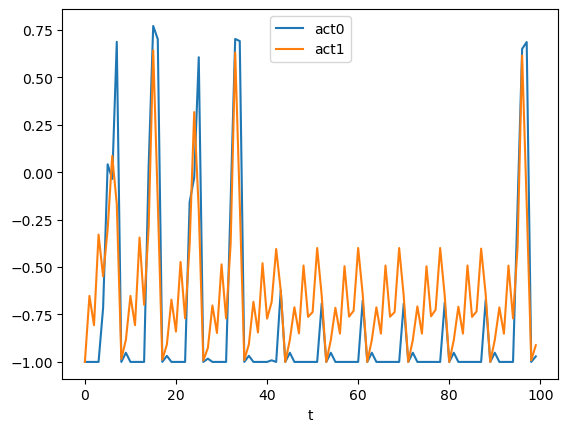

In [33]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


<Axes: xlabel='t'>

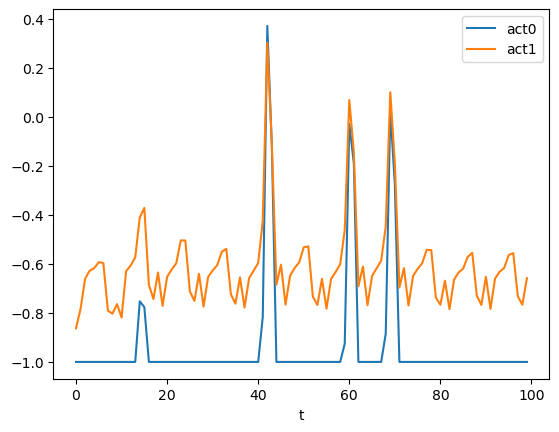

In [28]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)
ppoData = simulator(env = evalEnv, agent = ppoAgent_var).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF[ppoDataDF.rep == 1].plot(x='t', y =['act0', 'act1'])

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


<Axes: xlabel='t'>

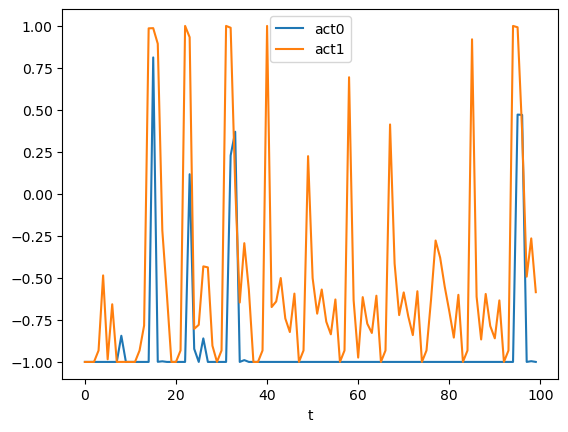

In [18]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)
td3Data = simulator(env = evalEnv, agent = td3Agent).simulate_full_named_dict_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


<Axes: xlabel='t'>

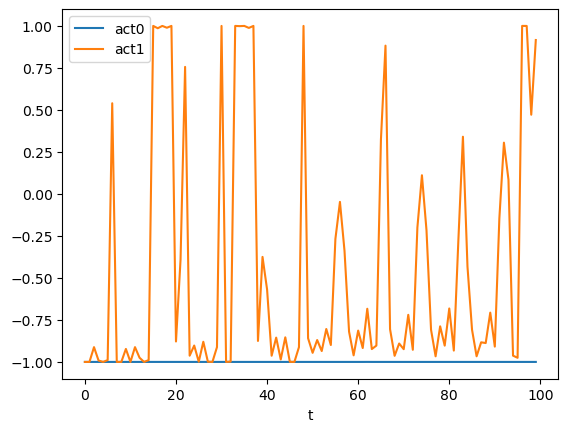

In [19]:
evalEnv = greenCrabMonthEnvTwoActNormalized(config)
td3Data = simulator(env = evalEnv, agent = td3Agent_var).simulate_full_named_dict_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


<Axes: xlabel='t'>

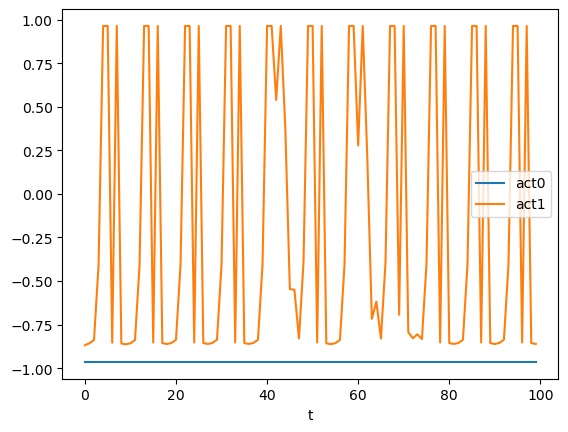

In [49]:
evalEnv = greenCrabMonthEnvTwoActSizeNormalized(config)
tqcData = simulator(env = evalEnv, agent = tqcAgent).simulate_full_named_dict_obs_acts()
tqcDataDF = pd.DataFrame(tqcData)
tqcDataDF[tqcDataDF.rep == 1].plot(x='t', y =['act0', 'act1'])

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


<Axes: xlabel='t'>

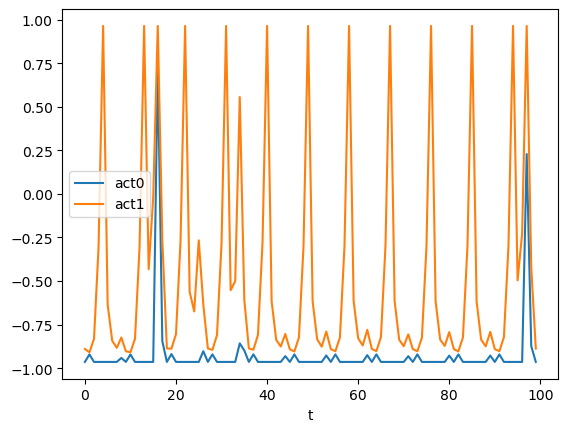

In [50]:
evalEnv = greenCrabMonthEnvTwoActSizeNormalized(config)
tqcData = simulator(env = evalEnv, agent = tqcAgent_var).simulate_full_named_dict_obs_acts()
tqcDataDF = pd.DataFrame(tqcData)
tqcDataDF[tqcDataDF.rep == 0].plot(x='t', y =['act0', 'act1'])

In [39]:
evalEnv = greenCrabMonthEnvTwoActSizeNormalized(config)
ppoData = simulator(env = evalEnv, agent = recurrentPPOAgent_var).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head(100)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


,t,obs0,obs1,act0,act1,rew,rep
0,0,-1.0,-1.0,-1.000000,-1.000000,0.000000,0
1,1,-1.0,-1.0,-1.000000,-1.000000,-0.000061,0
2,2,-1.0,-1.0,-1.000000,-1.000000,-0.000123,0
3,3,-1.0,-1.0,-1.000000,-1.000000,-0.000184,0
4,4,-1.0,-1.0,-1.000000,-1.000000,-0.000245,0
...,...,...,...,...,...,...,...
95,95,-1.0,-1.0,-1.000000,-1.000000,-13.095438,0
96,96,-1.0,-1.0,-1.000000,-0.846405,-13.360406,0
97,97,-1.0,-1.0,-1.000000,-0.859551,-13.631549,0
98,98,-1.0,-1.0,-1.000000,-1.000000,-13.902167,0


<Axes: xlabel='t'>

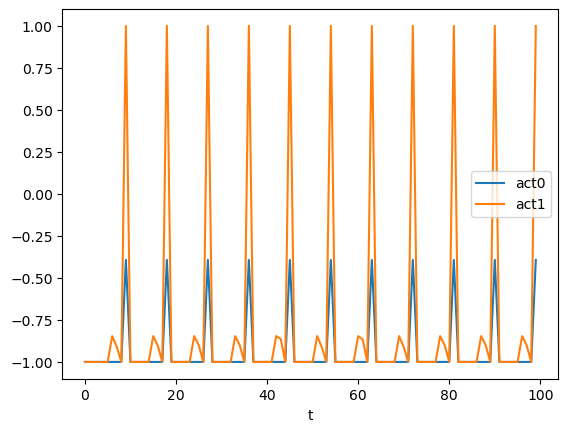

In [38]:
ppoDataDF[ppoDataDF.rep == 1].plot(x='t', y =['act0', 'act1'])

## Data Generation

In [46]:
agent_dir = '../saved_agents/twoActEnv'
env_id = 'twoactmonthsizenorm'
td3Agent = TD3.load(f"{agent_dir}/TD3-{env_id}-1", device="cpu")
ppoAgent = PPO.load(f"{agent_dir}/PPO-{env_id}-1", device="cpu")
tqcAgent = TQC.load(f"{agent_dir}/TQC-{env_id}-1", device="cpu")
recurrentPPOAgent = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-{env_id}-1", device="cpu")

In [47]:
td3Agent_var = TD3.load(f"{agent_dir}/TD3-{env_id}-2", device="cpu")
ppoAgent_var = PPO.load(f"{agent_dir}/PPO-{env_id}-2", device="cpu")
tqcAgent_var = TQC.load(f"{agent_dir}/TQC-{env_id}-2", device="cpu")
recurrentPPOAgent_var = RecurrentPPO.load(f"{agent_dir}/RecurrentPPO-{env_id}-2", device="cpu")

In [13]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}

evalEnv =  greenCrabMonthEnvTwoActSizeNormalized(config)
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [14]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -5.393775962306417
TQC mean rew = -5.342054961133874
TD3 mean rew = -9.49662425377428
RecurrentPPO mean rew = -21.28400109895868



In [51]:
ppo_rew = evaluate_agent(agent=ppoAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent_var, env=evalEnv, ray_remote=False).evaluate(n_eval_episodes=N_EPS)

In [52]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -5.142742234581541
TQC mean rew = -4.8152320881006325
TD3 mean rew = -9.359546312885646
RecurrentPPO mean rew = -10.55683506703148



In [43]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0,
    'control_randomness': True
    # "curriculum": True
}

In [44]:
dir_name = 'greencrab_two_act_size_env/new'

### no variance penalty

In [12]:
evalEnv =  greenCrabMonthEnvTwoActSizeNormalized(config)
ppo_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/ppo_agent_size', 
                            env=evalEnv, 
                            agent=ppoAgent, 
                            save_dir='.')
df = ppo_plot_agent.gen_env_sim_df(rep=1, obs_names=['crabs','months'])
ppo_plot_agent.save_df(ppo_plot_agent.env_simulation_df, 'ppo_size_sim_500')

In [45]:
evalEnv =  greenCrabMonthEnvTwoActSizeNormalized(config)
rppo_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/rppo_agent_size_rep500', 
                            env=evalEnv, 
                            agent=recurrentPPOAgent, 
                            save_dir='.')
rppo_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
rppo_plot_agent.save_df(rppo_plot_agent.env_simulation_df, 'rppo_size_sim_500')

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [44]:
evalEnv =  greenCrabMonthEnvTwoActNormalized(config)
tqc_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/tqc_agent_size', 
                            env=evalEnv, 
                            agent=tqcAgent, 
                            save_dir='.')
tqc_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
tqc_plot_agent.save_df(tqc_plot_agent.env_simulation_df, 'tqc_size_sim_500')

In [58]:
evalEnv =  greenCrabMonthEnvTwoActNormalized(config)
td3_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/td3_agent_size_rep500', 
                            env=evalEnv, 
                            agent=td3Agent,
                            save_dir='.')
td3_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
td3_plot_agent.save_df(td3_plot_agent.env_simulation_df, 'td3_sim_500')

## with Variance Penalty

In [51]:
evalEnv =  greenCrabMonthEnvTwoActNormalized(config)
ppo_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/ppo_var_agent_size_rep500', 
                            env=evalEnv, 
                            agent=ppoAgent_var, 
                            save_dir='.')
df = ppo_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
ppo_plot_agent.save_df(ppo_plot_agent.env_simulation_df, 'ppo_var_size_sim_500')

In [54]:
evalEnv =  greenCrabMonthEnvTwoActNormalized(config)
td3_plot_agent = plot_agent(env_sim_df=None, 
                            agent_name=f'{dir_name}/td3_var_agent_size_rep500', 
                            env=evalEnv, 
                            agent=td3Agent_var,
                            save_dir='.')
td3_plot_agent.gen_env_sim_df(rep=500, obs_names=['crabs','months'])
td3_plot_agent.save_df(td3_plot_agent.env_simulation_df, 'td3_var_size_sim_500')